# RAG Example - LangChain

An example based from HuggingFace where we build a RAG architecture.

Source:
  * https://huggingface.co/learn/cookbook/en/rag_zephyr_langchain
  * https://huggingface.co/learn/cookbook/en/rag_evaluation


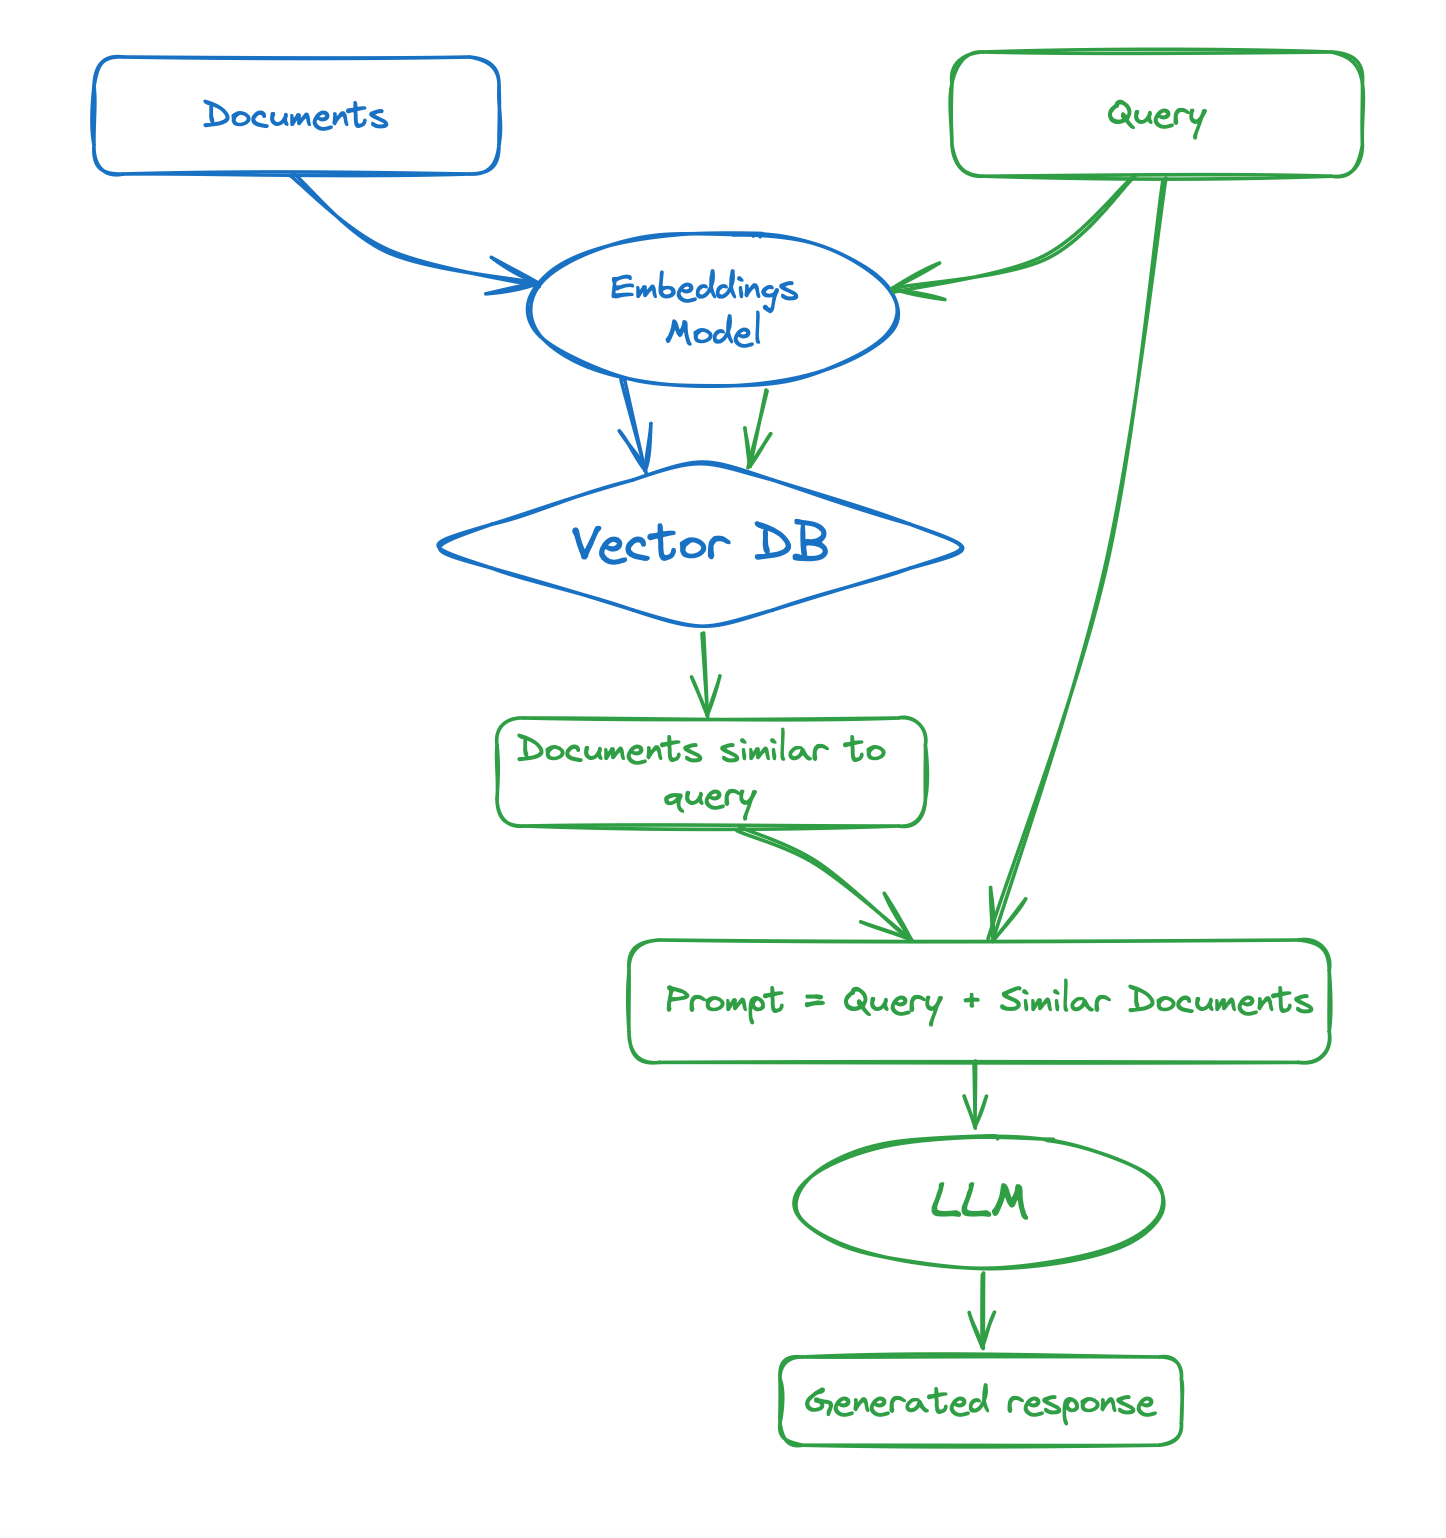

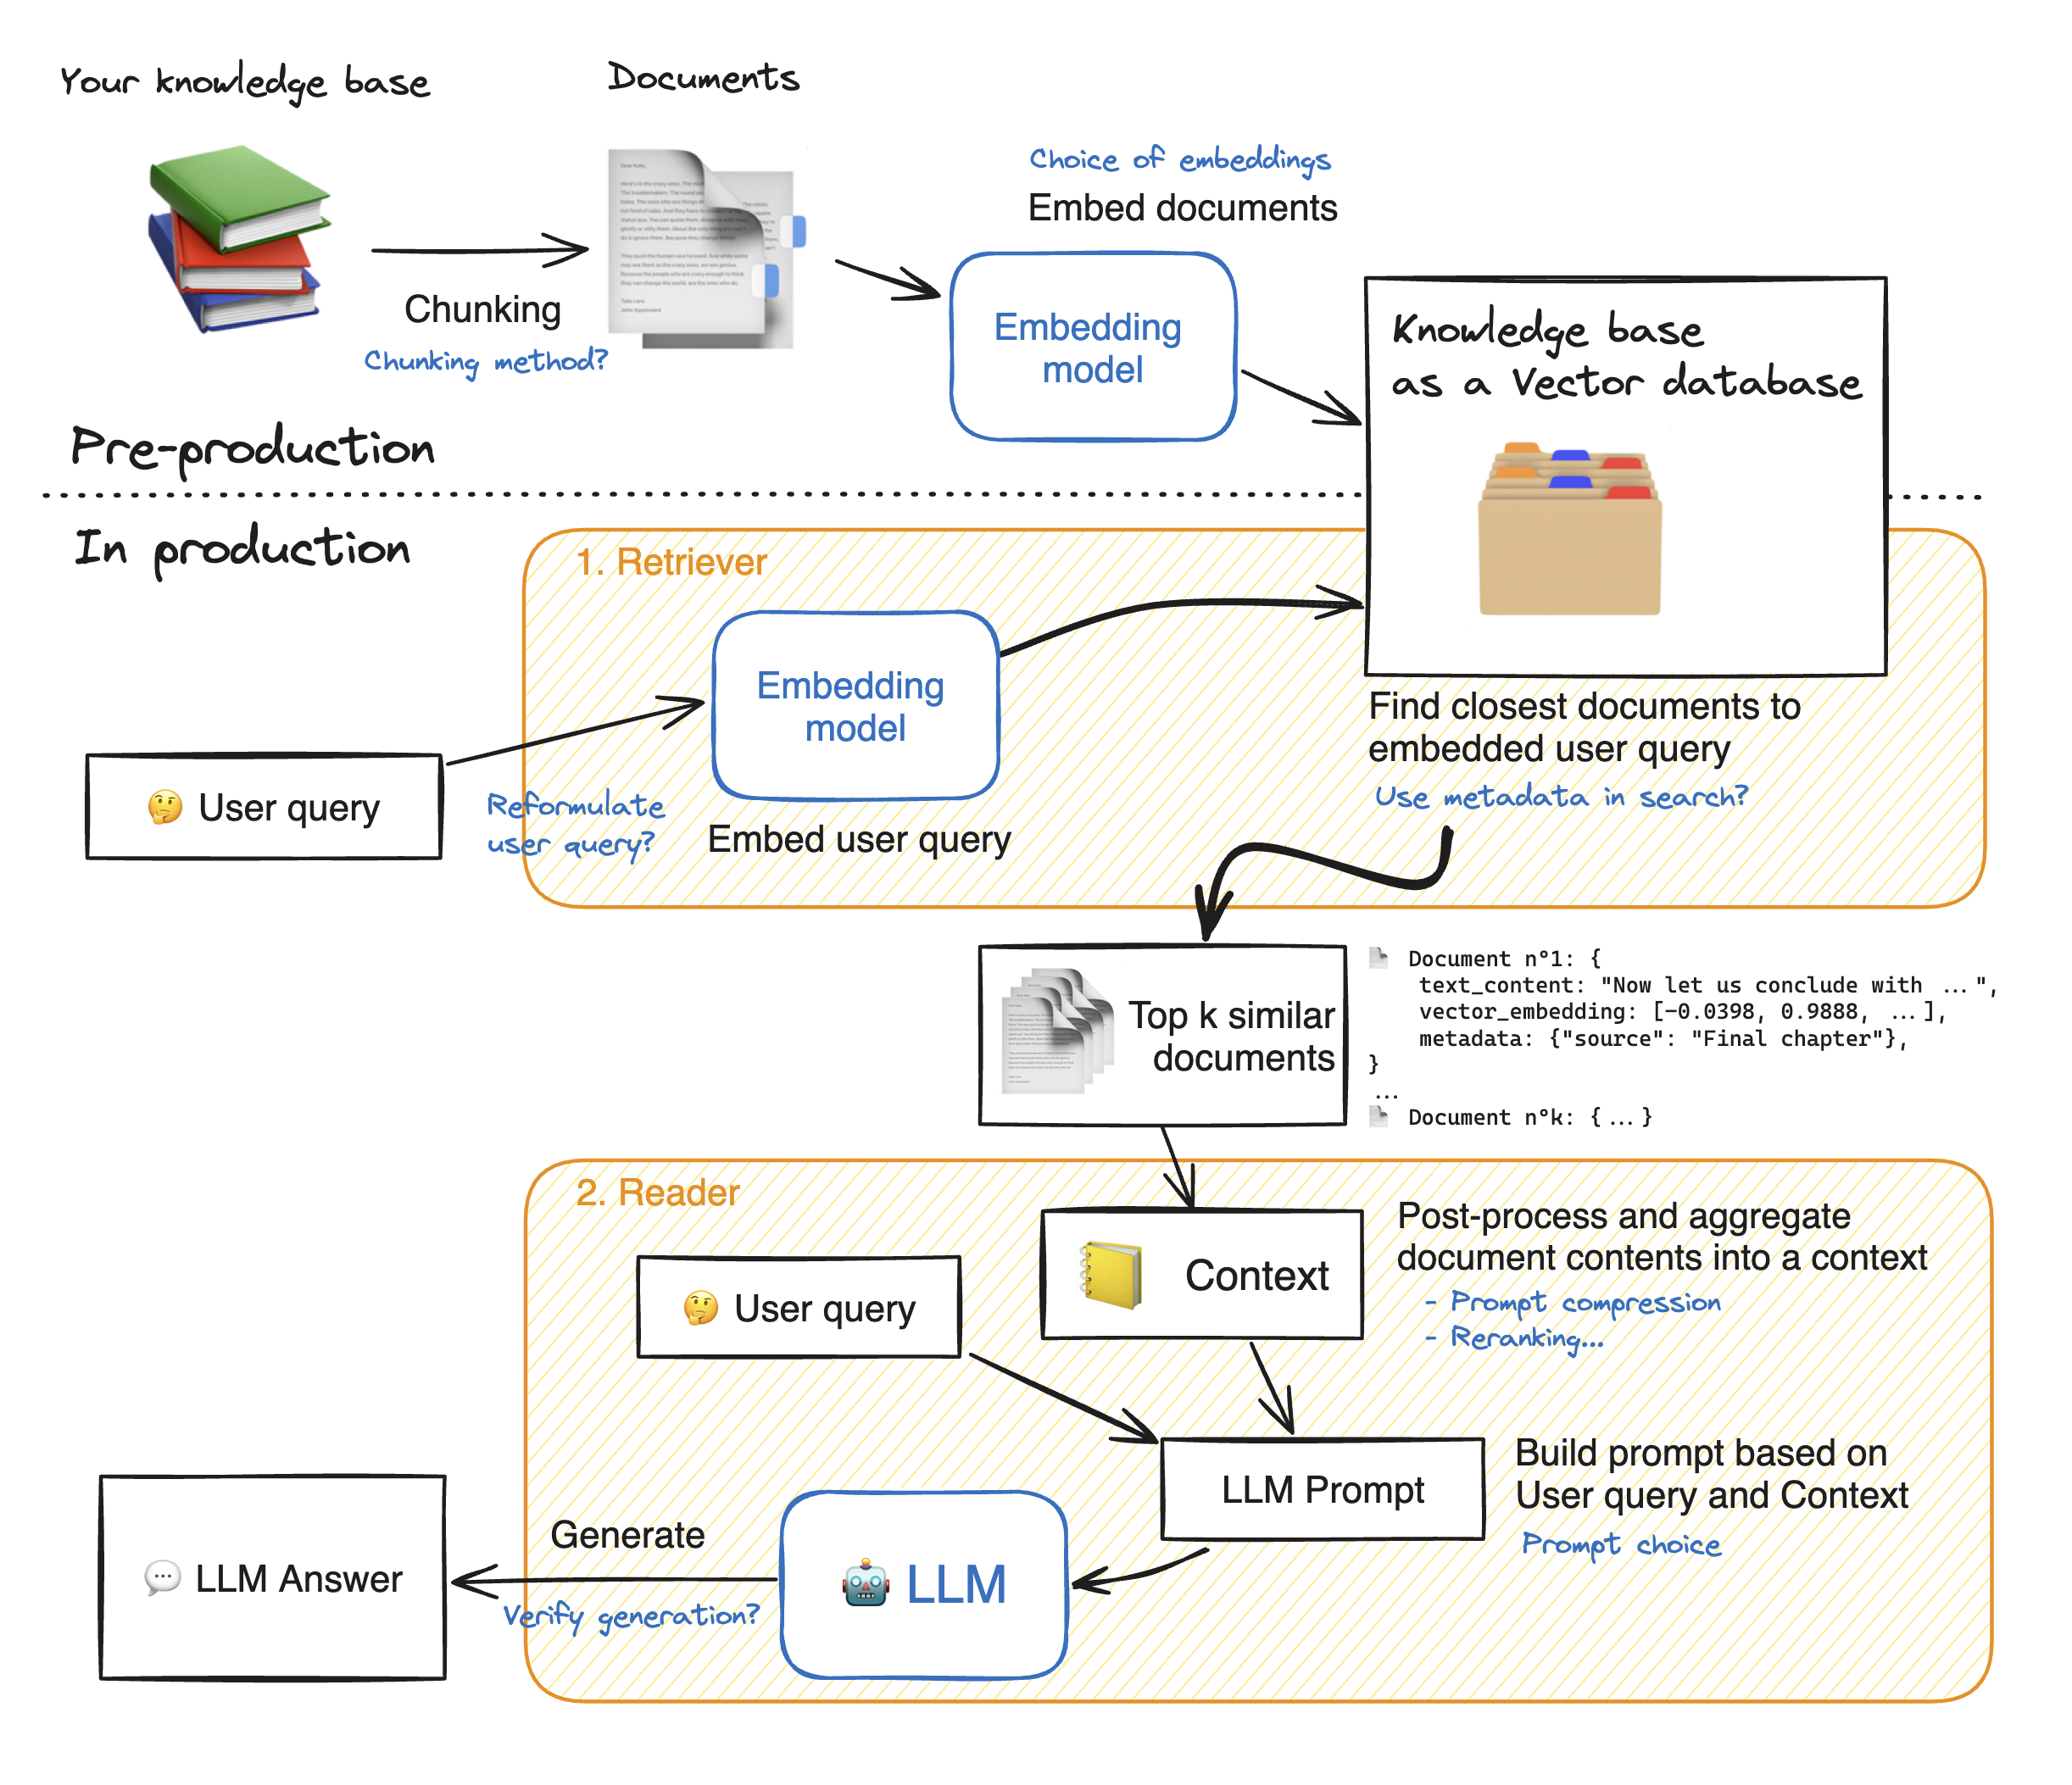

In [ ]:
import locale
from IPython.display import clear_output

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes transformers sentence-transformers faiss-gpu langchain
clear_output()

## 0. Initial setup

In [ ]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Load dataset for RAG

* As a reference, we load all of the issues (both open and closed) from PEFT library's repo.

In [ ]:
from langchain.document_loaders import GitHubIssuesLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [ ]:
# Load dataset
loader = GitHubIssuesLoader(
    repo="huggingface/peft",
    access_token=os.environ['GITHUB_TOKEN'],
    include_prs=False,
    state="all"
)
docs = loader.load()
clear_output()

In [ ]:
docs[0]

Document(page_content='### Feature request\n\nEETQ: https://github.com/NetEase-FuXi/EETQ\r\n\r\nEETQ quantization is with great performance during inference supported by TGI and LoRAX already, so that if it could be supported by finetuning that would be great for QLoRA training and inference.\n\n### Motivation\n\nAchieve good inference performance for QLoRA-ed model.\n\n### Your contribution\n\nMay be preparing PR, but depends on the complexity.', metadata={'url': 'https://github.com/huggingface/peft/issues/1643', 'title': 'Support EETQ QLoRA', 'creator': 'thincal', 'created_at': '2024-04-12T13:56:02Z', 'comments': 1, 'state': 'open', 'labels': [], 'assignee': None, 'milestone': None, 'locked': False, 'number': 1643, 'is_pull_request': False})

In [ ]:
len(docs)

849

In [ ]:
# If we want to embed all of the available content, we need to chunk the documents into appropriately sized pieces.
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs[:30])

In [ ]:
for i in range(len(docs)):
  if len(docs[i].page_content)>512:
    print(docs[i].page_content)
    print("="*100)
    print()
    print(chunked_docs[i].page_content)
    break

### System Info

accelerate==0.28.0
diffusers==0.27.0
peft==0.9.0
transformers==4.38.2

Amazon EC2 instance (g5.2xlarge)
Deep Learning OSS Nvidia Driver AMI GPU PyTorch 2.0.1 (Amazon Linux 2)


### Who can help?

@pacman100 @younesbelkada

### Information

- [ ] The official example scripts
- [X] My own modified scripts

### Tasks

- [X] An officially supported task in the `examples` folder
- [ ] My own task or dataset (give details below)

### Reproduction

Problem Setup
---
I am using the `peft` library to run SDXL + LoRA inference. We aim to support thousands of LoRAs. Here is the high-level algorithm that we are using on each query.

At model setup time, we load an SDXL model:
```
t2i_pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16").to("cuda")
```

Then, for each query:

**Step 1**: Load the adapter into GPU, either from disk or CPU.
```
ensure_lora_is_on_gpu(request.adapter)
t2i_pip

## 2. Create the embeddings + retriever

* Create a database with their embeddings
* We use an embeddings model from HuggingFace (https://huggingface.co/spaces/mteb/leaderboard). E.g., BAAI/bge-base-en-v1.5 embeddings model.

In [ ]:
embedding_model = "BAAI/bge-base-en-v1.5"
db = FAISS.from_documents(
    chunked_docs,
    HuggingFaceEmbeddings(model_name=embedding_model)
)

In [ ]:
# Method for returning (retrieve) the documents given an unstructured query.
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

In [ ]:
# Save backup DB
f_path_db = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/generative_ai/faiss_index"
db.save_local(f_path_db)
# new_db = FAISS.load_local("faiss_index", embeddings)
# docs = new_db.similarity_search(query)


In [ ]:
# Querying
query = "What's the latest issue?"
docs = db.similarity_search(query)
print(docs[0].page_content)

In [ ]:
# Retriever
retriever = db.as_retriever()
docs = retriever.invoke(query)
print(docs[0].page_content)

## 3. Load LLM

* https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

In [ ]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
clear_output()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
# Load model

#model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "HuggingFaceH4/zephyr-7b-beta"
#model_name = "google/gemma-7b"
#model_name = "google/flan-ul2"

'''
task = 'text-generation'
dct_llm_params = {
    "max_new_tokens": 128,
    #"top_k": 5,
    "temperature": 0.3,
    #"repetition_penalty": 1.03,
}

llm = HuggingFaceHub(
    repo_id=model_name,
    task=task,
    model_kwargs=dct_llm_params,
)
'''

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Setup the LLM chain
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=400,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

prompt_template = """
<|system|>
Answer the question based on your knowledge. Use the following context to help:

{context}

</s>
<|user|>
{question}
</s>
<|assistant|>

 """

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

llm_chain = prompt | llm | StrOutputParser()


In [ ]:
# Combine de LLM chain w/ the retriever
#retriever = db.as_retriever()
rag_chain = {"context": retriever, "question": RunnablePassthrough()} | llm_chain

## 4. Evaluation
* RAG vs no RAG

In [ ]:
# Compare the results
question = "How do you combine multiple adapters?"

In [ ]:
# Answering w/o RAG
llm_chain.invoke({"context": "", "question": question})

In [ ]:
# Answering w/ RAG
rag_chain.invoke(question)

# RAG Example - LangChain (II)

* References: https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/05-langchain-retrieval-augmentation.ipynb

In [ ]:
!pip install -qU datasets apache_beam mwparserfromhell langchain pinecone-client==3.1.0 tiktoken==0.5.2 faiss-gpu

In [ ]:
#!pip install -e .
#!pip install --no-deps multiprocess>=0.70.11

## 0. Setup

In [ ]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 1. Build dataset

In [ ]:
import tiktoken
import pandas as pd
#from datasets import load_dataset
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFaceHub
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document

In [ ]:
df_input = pd.read_parquet('/content/drive/MyDrive/GitHub/python-codebase/machine_learning/datasets/train-00040-of-00041.parquet', engine='pyarrow')

In [ ]:
df_input.head()

,id,url,title,text
0,67963775,https://en.wikipedia.org/wiki/The%20Angel%20of...,The Angel of 8th Ave.,"""The Angel of 8th Ave."" (stylised in all lower..."
1,67963778,https://en.wikipedia.org/wiki/Hurricane%20Muni...,Hurricane Municipal Airport,"Hurricane Municipal Airport , also known as Ge..."
2,67963783,https://en.wikipedia.org/wiki/Satin%20berrypecker,Satin berrypecker,"The satin berrypecker (Melanocharis citreola),..."
3,67963841,https://en.wikipedia.org/wiki/Cassinia%20compl...,Cassinia complanata,"Cassinia complanata, commonly known as smooth ..."
4,67963851,https://en.wikipedia.org/wiki/Monoporella,Monoporella,Monoporella is a genus of bryozoans belonging ...


In [ ]:
len(df_input)

157528

In [ ]:
# create the length function
tokenizer = tiktoken.get_encoding('cl100k_base')

def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [ ]:
# Example: check length
tiktoken_len("hello I am a chunk of text and using the tiktoken_len function "
             "we can find the length of this chunk of text in tokens")

26

In [ ]:
# Build Knowledge Base
#data = load_dataset("wikipedia", "20220301.simple", split='train[:10000]')
#data

In [ ]:
#data[6]

We now aim to chunk these articles into more "concise" chunks to later be embedding and stored in our Pinecone vector database.

In [ ]:
# Text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

In [ ]:
chunks = text_splitter.split_text(df_input['text'].values[9])[:3]
chunks

['Otohydra is a genus of cnidarians belonging to the monotypic family Otohydridae.\n\nSpecies:\n\nOtohydra tremulans \nOtohydra vagans\n\nReferences\n\nActinulida\nHydrozoan genera']

In [ ]:
tiktoken_len(chunks[0])

54

## 2. Create vector DB

In [ ]:
chunks = [text_splitter.split_text(x) for x in list(df_input['text'].values)[:200]]
chunks[0]

['"The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band\'s third studio album, Angel in Realtime (2022).\n\nFrontman David Le\'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."\n\nAt the 2021 ARIA Music Awards, the song earned a nomination for Best Group.\n\nMusic video\nThe music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of London.\n\nCritical reception\nAl Newstead from Triple J called it a "big, cathartic rock number." Emmy Mack from Music Feeds said, "it\'s made of the same poetic, life-affirming, retro-infused indie rock that fans have grown to know and love from Gang of Youths".\n\nChart performance\nOn 23 June 2021, Australian Recording Industry Association (ARIA) released their mid-week 

In [ ]:
list_of_documents = []
for page_content in chunks:
  concat_text = ""
  for text in page_content:
    concat_text = concat_text + ' ' + text
    list_of_documents.append(Document(page_content=concat_text, metadata=dict(page=1)))

In [ ]:
embedding_model = "BAAI/bge-base-en-v1.5"
db = FAISS.from_documents(
    list_of_documents,
    HuggingFaceEmbeddings(model_name=embedding_model)
)

In [ ]:
# Method for returning (retrieve) the documents given an unstructured query.
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

In [ ]:
# Querying
query = "What's the Angel of 8th Ave.?"
docs = db.similarity_search(query)
print(docs[0].page_content)

 "The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band's third studio album, Angel in Realtime (2022).

Frontman David Le'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."

At the 2021 ARIA Music Awards, the song earned a nomination for Best Group.

Music video
The music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of London.

Critical reception
Al Newstead from Triple J called it a "big, cathartic rock number." Emmy Mack from Music Feeds said, "it's made of the same poetic, life-affirming, retro-infused indie rock that fans have grown to know and love from Gang of Youths".

Chart performance
On 23 June 2021, Australian Recording Industry Association (ARIA) released their mid-week chart report, whi

In [ ]:
# Retriever
retriever = db.as_retriever()
docs = retriever.invoke(query)
print(docs[0].page_content)

 "The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band's third studio album, Angel in Realtime (2022).

Frontman David Le'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."

At the 2021 ARIA Music Awards, the song earned a nomination for Best Group.

Music video
The music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of London.

Critical reception
Al Newstead from Triple J called it a "big, cathartic rock number." Emmy Mack from Music Feeds said, "it's made of the same poetic, life-affirming, retro-infused indie rock that fans have grown to know and love from Gang of Youths".

Chart performance
On 23 June 2021, Australian Recording Industry Association (ARIA) released their mid-week chart report, whi

## 4. Build RAG

* Reference: https://huggingface.co/learn/cookbook/en/rag_evaluation

In [ ]:
# Get relevant docs
question = "What's the Angel of 8th Ave.?"
num_retrieved_docs = 3
relevant_docs = db.similarity_search(query=question, k=num_retrieved_docs)
relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

In [ ]:
relevant_docs[0]

' "The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band\'s third studio album, Angel in Realtime (2022).\n\nFrontman David Le\'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."\n\nAt the 2021 ARIA Music Awards, the song earned a nomination for Best Group.\n\nMusic video\nThe music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of London.\n\nCritical reception\nAl Newstead from Triple J called it a "big, cathartic rock number." Emmy Mack from Music Feeds said, "it\'s made of the same poetic, life-affirming, retro-infused indie rock that fans have grown to know and love from Gang of Youths".\n\nChart performance\nOn 23 June 2021, Australian Recording Industry Association (ARIA) released their mid-week 

In [ ]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [ ]:
repo_id = "HuggingFaceH4/zephyr-7b-beta"

llm = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 2000,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

In [ ]:
# Build the final prompt
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

# Redact an answer
answer = llm(final_prompt)

In [ ]:
print(answer)


<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:

Extracted documents:
Document 0:::
 "The Angel of 8th Ave." (stylised in all lowercase) is a song by Australian alternative rock band Gang of Youths, released on 15 June 2021 as the lead single from their second EP, Total Serene (2021). The track also features on the band's third studio album, Angel in Realtime (2022).

Frontman David Le'aupepe said the song was inspired by "falling in love and finding a new life in a new city together."

At the 2021 ARIA Music Awards, the song earned a nomination for Best Group.

Music video
The music video was released on 16 June 2021. The video was directed by Joel Barney and filmed in the Angel area of L

# RAG Example - LlamaIndex

* Using LlamaIndex as Vector DB
* Reference: https://huggingface.co/learn/cookbook/en/rag_llamaindex_librarian

In [1]:
%pip install -q \
    llama-index \
    EbookLib \
    html2text \
    llama-index-embeddings-huggingface \
    llama-index-llms-ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.1/136.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [26]:
%pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [2]:
!brew install ollama

/bin/bash: line 1: brew: command not found


## 1. Prepare data

In [7]:
!mkdir -p "/content/test/library/jane-austen"
!mkdir -p "/content/test/library/victor-hugo"
!wget https://www.gutenberg.org/ebooks/1342.epub.noimages -O "/content/test/library/jane-austen/pride-and-prejudice.epub"
!wget https://www.gutenberg.org/ebooks/135.epub.noimages -O "/content/test/library/victor-hugo/les-miserables.epub"

--2024-04-13 09:26:32--  https://www.gutenberg.org/ebooks/1342.epub.noimages
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/1342/pg1342.epub [following]
--2024-04-13 09:26:33--  https://www.gutenberg.org/cache/epub/1342/pg1342.epub
Reusing existing connection to www.gutenberg.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 563922 (551K) [application/epub+zip]
Saving to: ‘/content/test/library/jane-austen/pride-and-prejudice.epub’

/content/test/libra 100%[===================>] 550.71K  --.-KB/s    in 0.1s    

2024-04-13 09:26:33 (4.66 MB/s) - ‘/content/test/library/jane-austen/pride-and-prejudice.epub’ saved [563922/563922]

--2024-04-13 09:26:33--  https://www.gutenberg.org/ebooks/135.epub.noimages
Resolving www.gutenberg.org (www.gutenber

In [4]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HUGGINGFACEHUB_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

## 2. Create Vector DB

RAG with LlamaIndex phases:
* **Loading**: For indicating to LlamaIndex where the data is located and how to load it
* **Indexing**: Augment the loaded data to facilitate querying, e.g. with vector embeddings
* **Querying**: We configure an LLM to act as the query interface for the indexed data.

Other steps:
* **Storing**: once the data is indexed we will almost always want to store the index, as well as other metadata, to avoid having to re-index it.
* **Evaluation**: Evaluation provides objective measures of how accurate, faithful and fast the responses to queries are.

* Reference: https://docs.llamaindex.ai/en/stable/getting_started/concepts/


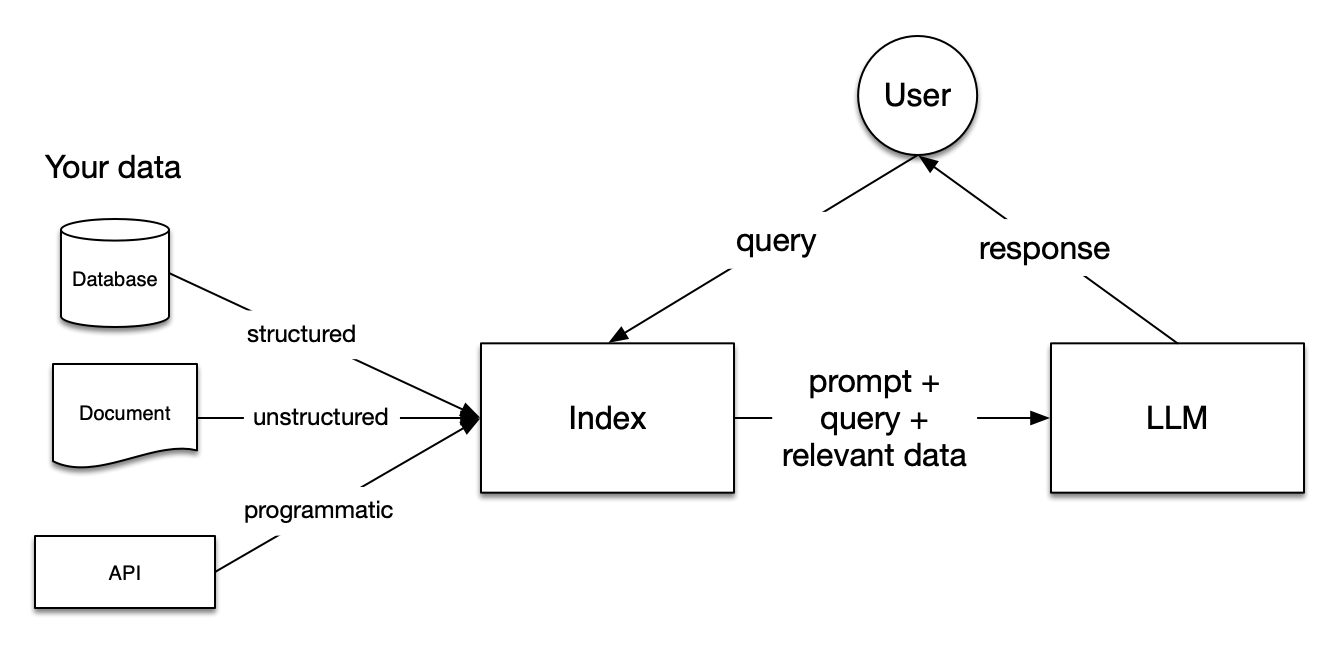

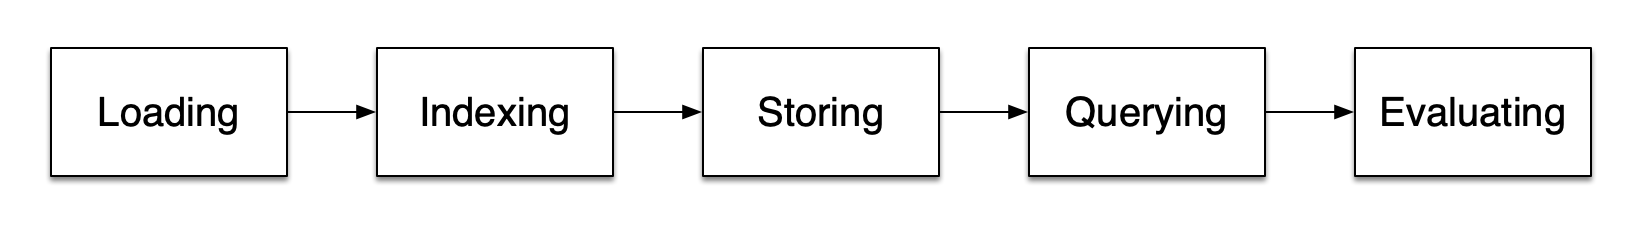

In [8]:
## 1. Loading
# SimpleDirectoryReader.load_data() converts our ebooks into a set of Documents for LlamaIndex to work with.
# Documents have not been chunked at this stage — that will happen during indexing
from llama_index.core import SimpleDirectoryReader

loader = SimpleDirectoryReader(
    input_dir="/content/test/",
    recursive=True,
    required_exts=[".epub"],
)
documents = loader.load_data()

In [17]:
documents[0].text[1200:1500]

'TER_II) [III.,\n](8528395013653884923_1342-h-1.htm.html#CHAPTER_III) [IV.,\n](8528395013653884923_1342-h-1.htm.html#CHAPTER_IV) [V.,\n](8528395013653884923_1342-h-1.htm.html#CHAPTER_V) [VI.,\n](8528395013653884923_1342-h-1.htm.html#CHAPTER_VI) [VII.,\n](8528395013653884923_1342-h-1.htm.html#CHAPTER_VII) '

In [19]:
## 2. Indexing
# Indexing the data will allow our RAG pipeline to look up the relevant context for our query to pass to our LLM to augment their generated response
# This is also where document chunking will take place
# VectorStoreIndex (default) uses a simple, in-memory dictionary to store the indices, but LlamaIndex also supports a wide variety of vector storage solutions for you to graduate to as you scale.
# By default, LlamaIndex uses a chunk size of 1024 and a chunk overlap of 20, and uses OpenAI (specifically gpt-3.5-turbo)

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex

In [20]:
# Embedding model
model_name="BAAI/bge-small-en-v1.5"
embedding_model = HuggingFaceEmbedding(
    model_name=model_name
)

# Create index
index = VectorStoreIndex.from_documents(
    documents,
    embed_model=embedding_model,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [30]:
## 3. Querying
# Final step within the RAG pipeline
# For this example, we will use Llama 2
# We need to start up the Ollama server, but there is no support in the Ollama Python client for actually starting and stopping the server itself
# run: ollama serve. Remember to terminate this after we’re done
# For Ollama usage within Colab: https://stackoverflow.com/questions/77697302/how-to-run-ollama-in-google-colab
!curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10044    0 10044    0     0  33710      0 --:--:-- --:--:-- --:--:-- 33818
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [22]:
from llama_index.llms.ollama import Ollama

llama = Ollama(
    model="llama2",
    request_timeout=40.0,
)

query_engine = index.as_query_engine(
    llm=llama
)

In [ ]:
## 4. Final Result
print(
    query_engine.query(
        "What are the titles of all the books available? Show me the context used to derive your answer."
    )
)

In [ ]:
print(query_engine.query("Who is the main character of 'Pride and Prejudice'?"))

In [27]:
from langchain_community.llms import HuggingFaceHub

repo_id = "HuggingFaceH4/zephyr-7b-beta"
llm = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 2000,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.huggingface_hub.HuggingFaceHub` was deprecated in langchain-community 0.0.21 and will be removed in 0.2.0. Use HuggingFaceEndpoint instead.
  warn_deprecated(


# Other

## 1. HF Inference

In [ ]:
import json

from huggingface_hub import InferenceClient

In [ ]:
repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_client = InferenceClient(
    model=repo_id,
    timeout=120,
)


def call_llm(inference_client: InferenceClient, prompt: str):
    response = inference_client.post(
        json={
            "inputs": prompt,
            "parameters": {"max_new_tokens": 1000},
            "task": "text-generation",
        },
    )
    return json.loads(response.decode())[0]["generated_text"]


call_llm(llm_client, "This is a test context")

'This is a test context for the `@mui/material` library.\n\n## Installation\n\n```sh\nnpm install @mui/material\n```\n\n## Usage\n\n```jsx\nimport React from \'react\';\nimport { Button } from \'@mui/material\';\n\nfunction App() {\n  return (\n    <div className="App">\n      <Button variant="contained" color="primary">\n        Hello World\n      </Button>\n    </div>\n  );\n}\n\nexport default App;\n```\n\n## Documentation\n\n- [Material-UI](https://material-ui.com/)\n- [Material Design](https://material.io/)'

## 2. LangChain tools

In [ ]:
from langchain.agents import load_tools
from langchain_community.llms import HuggingFaceHub
from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType

In [ ]:
def execute_chain(chain, query):
  result = chain.run(query)
  return result

In [ ]:
repo_id = "HuggingFaceH4/zephyr-7b-beta"

llm = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 2000,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

In [ ]:
tools = load_tools(
    ["llm-math"],
    llm=llm
)

In [ ]:
memory = ConversationBufferMemory(memory_key="chat_history")

In [ ]:
conversational_agent = initialize_agent(
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    memory=memory,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
'''
result = execute_chain(
    conversational_agent,
    "What's the result of an investment of $10,000 growing at 8% annually for 5 years with compound interest?"
)
print(result)
'''